In [1]:
import os
os.chdir("../")

import semiolog as slg

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
from ipywidgets import interact

In [3]:
semiotic = slg.Cenematic("en_bnc")

SLG [I]: Checking config correctness... Config correct!


100%|██████████| 3/3 [00:00<00:00, 11.08it/s]

SLG [I]: Dataset loaded from disk (TXT files)
SLG [I]: Vocabulary loaded from disk


  0%|          | 0/3 [00:00<?, ?it/s]

SLG [I]: nGrams loaded from disk (['2_5.json', '3_5.json', '4_5.json'])


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at models/en_bnc/paradigms/tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


SLG [I]: Paradigmatizer loaded from disk


In [4]:
sent = semiotic.corpus.train[565]["text"]
semiotic.syntagmatic.tokenizer.normalizer.normalize_str(sent)

'another500eastgermanscameoutthroughhungaryinthe24hourstoyesterdaymorningbringingthetotalwhohaveleftsincehungaryopeneditsborderson11septemberto26500'

In [5]:
norm_factor = 1/sum(semiotic.vocab.alpha.values())

In [6]:
sum([v*norm_factor for k,v in semiotic.vocab.alpha.items() if v>0][:37])

0.9998785559224672

In [7]:
ng2 = semiotic.vocab.ng2_5.freq
ng2_bpe = {k:v for k,v in semiotic.vocab.freq.items() if len(k)==2}
ng3 = semiotic.vocab.ng3_5.freq
ng3_bpe = {k:v for k,v in semiotic.vocab.freq.items() if len(k)==3}

In [8]:
elements = [k for k,v in semiotic.vocab.alpha.items() if v>0][:60]
elements = sorted(elements)
elements_dict = {k:i for i,k in enumerate(elements)}


# vowels = list("aeiouy")
# elements = list(string.digits) + vowels + [l for l in string.ascii_lowercase if l not in vowels]

In [19]:
a_M = slg.util.build_term_context_matrix(elements, elements, ng2)
# a_M = slg.util.build_term_context_matrix(elements, elements, ng2_bpe)
a_M = a_M.toarray()
a_M_pmi = slg.util.build_pmi_matrix(a_M, type="npmi")
# a_M_pmi = slg.util.build_pmi_matrix(a_M+.0001, type="npmi")

Building oR Matrix...
Term-Context Matrix built in 0.0 secs.

Computing PMI Matrix...
Type: npmi
Done
PMI Matrix built in 0.01 secs.
Done



In [20]:

a_M_pmi_min = a_M_pmi.min()
if not any(a_M_pmi.data==0):
    a_M_pmi[a_M_pmi==0] = a_M_pmi_min

a_M_pmi = a_M_pmi.toarray()

a_M_ppmi = slg.util.build_pmi_matrix(a_M, type="ppmi")
a_M_ppmi = a_M_ppmi.toarray()

Computing PMI Matrix...
Type: ppmi
Done
PMI Matrix built in 0.01 secs.
Done



/Users/Gianni/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3441: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [21]:
sns.set(
    rc = {'figure.figsize':(25,20)},
    font="Courier"
    )

def plot(vector,
    xticklabels = None,
    yticklabels = None,
    vmin = None,
    vmax = None,
    ):
    hm = sns.heatmap(
        vector,
        xticklabels=xticklabels,
        yticklabels=yticklabels,
        linewidths=.5,
        cmap="coolwarm",#"YlGnBu",
        center = 0,
        vmin = vmin,
        vmax = vmax,
        square=True,
        ).tick_params(axis='both', which='major', labelsize=10, labelbottom = True, labelright = True, bottom=False, top = False, labeltop=True)
    
    return hm

In [22]:
def plot_cluster(
    vector,
    xticklabels = None,
    yticklabels = None,
    method = "complete",
    row_cluster = True,
    col_cluster = True,
    figsize = (15, 15),
    vmax = None,
    vmin = None,
    
    ):
    cm = sns.clustermap(
        vector,

        row_cluster=row_cluster,
        col_cluster=col_cluster,

        method=method,

        dendrogram_ratio=(.1, .1),

        figsize=figsize,
        xticklabels = xticklabels, 
        yticklabels = yticklabels,
        linewidths=.5,
        cmap="coolwarm",#"YlGnBu",
        center = 0,
        # vmin = -1,
        cbar_pos=(1.02, 0.03, .03, .87),
        square=True,

        )
    plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    return cm

/usr/local/lib/python3.9/site-packages/seaborn/matrix.py:1216: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


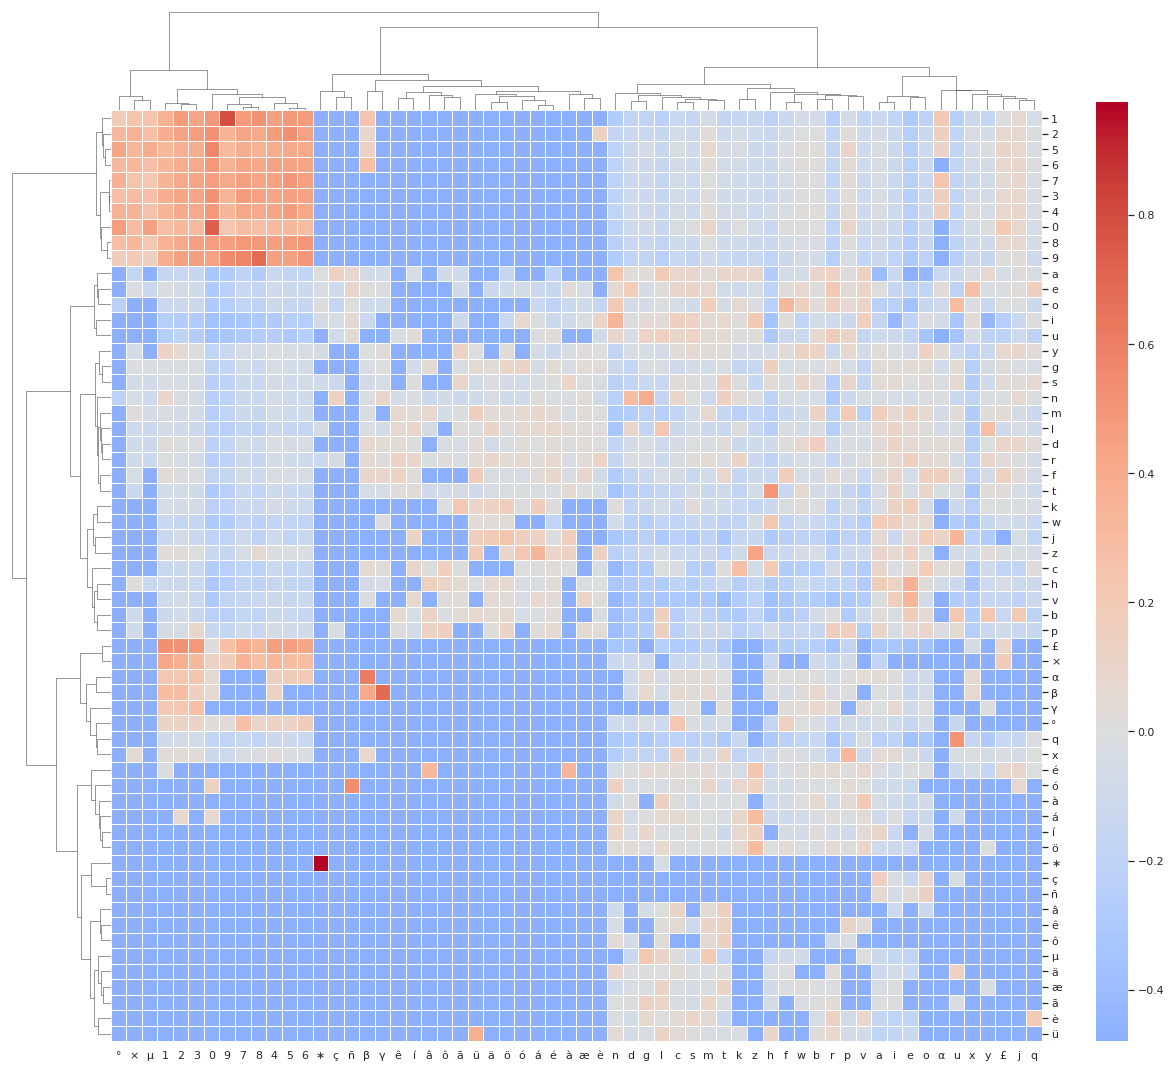

In [23]:
bla = plot_cluster(
    a_M_pmi,
    elements,
    elements,
    method = "ward"
)

findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.


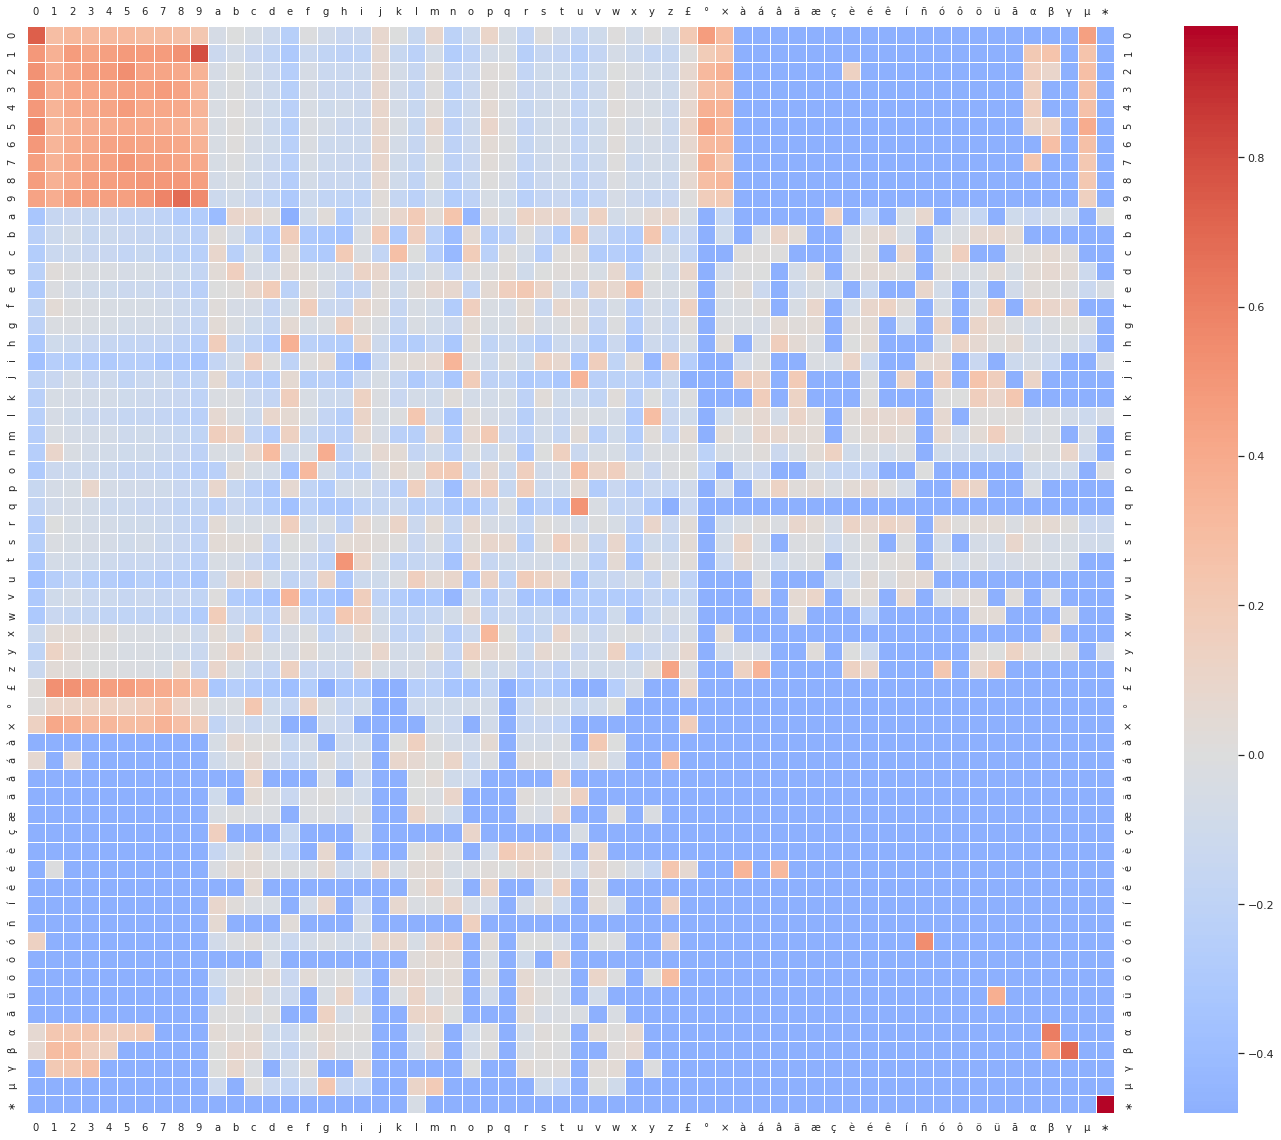

In [24]:
plot(a_M_pmi, elements, elements)

In [185]:
@interact(n=(0,100,1))
def f(n=0):
    matrix = a_M.copy()
    for l,r in list(ng2.keys())[:n]:
        matrix[elements_dict[l],elements_dict[r]] = 0
    bla = plot_cluster(
        # -np.log((matrix+1)/matrix.sum()),
        matrix,
        # a_M_pmi.clip(None,.0),
        elements,
        elements,
    )
    return bla

interactive(children=(IntSlider(value=0, description='n'), Output()), _dom_classes=('widget-interact',))

In [25]:
row_index = bla.dendrogram_row.reordered_ind
col_index = bla.dendrogram_col.reordered_ind

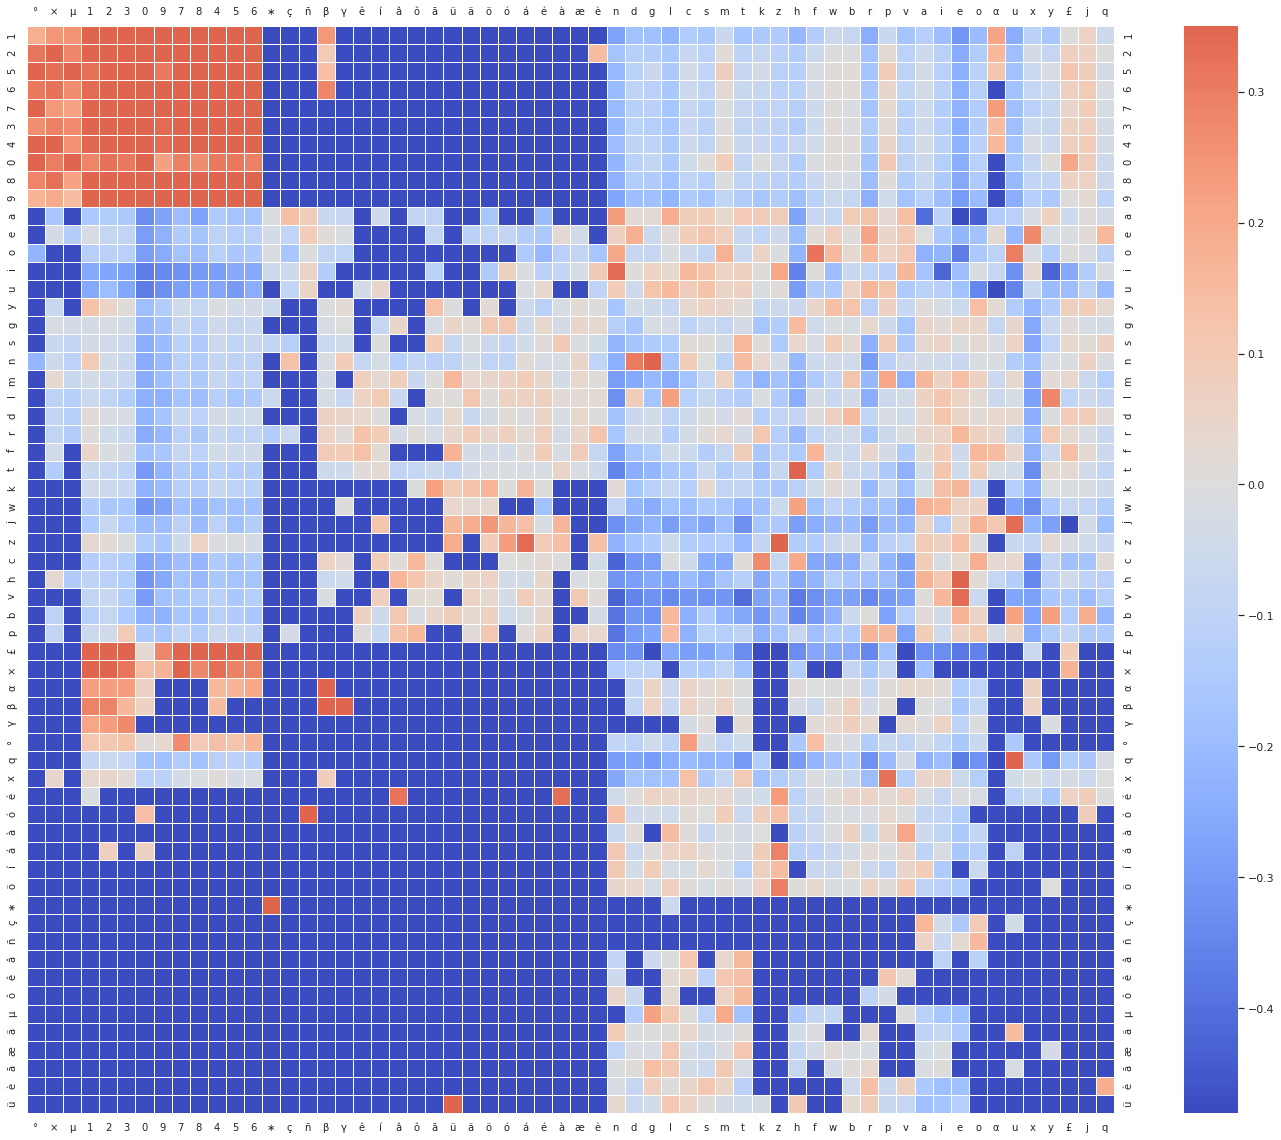

In [26]:
b = None
n = None
bla2 = plot(a_M_pmi[row_index[b:n]][:,col_index[b:n]], [elements[i] for i in col_index[b:n]], [elements[i] for i in row_index[b:n]],
vmax = .35,

)

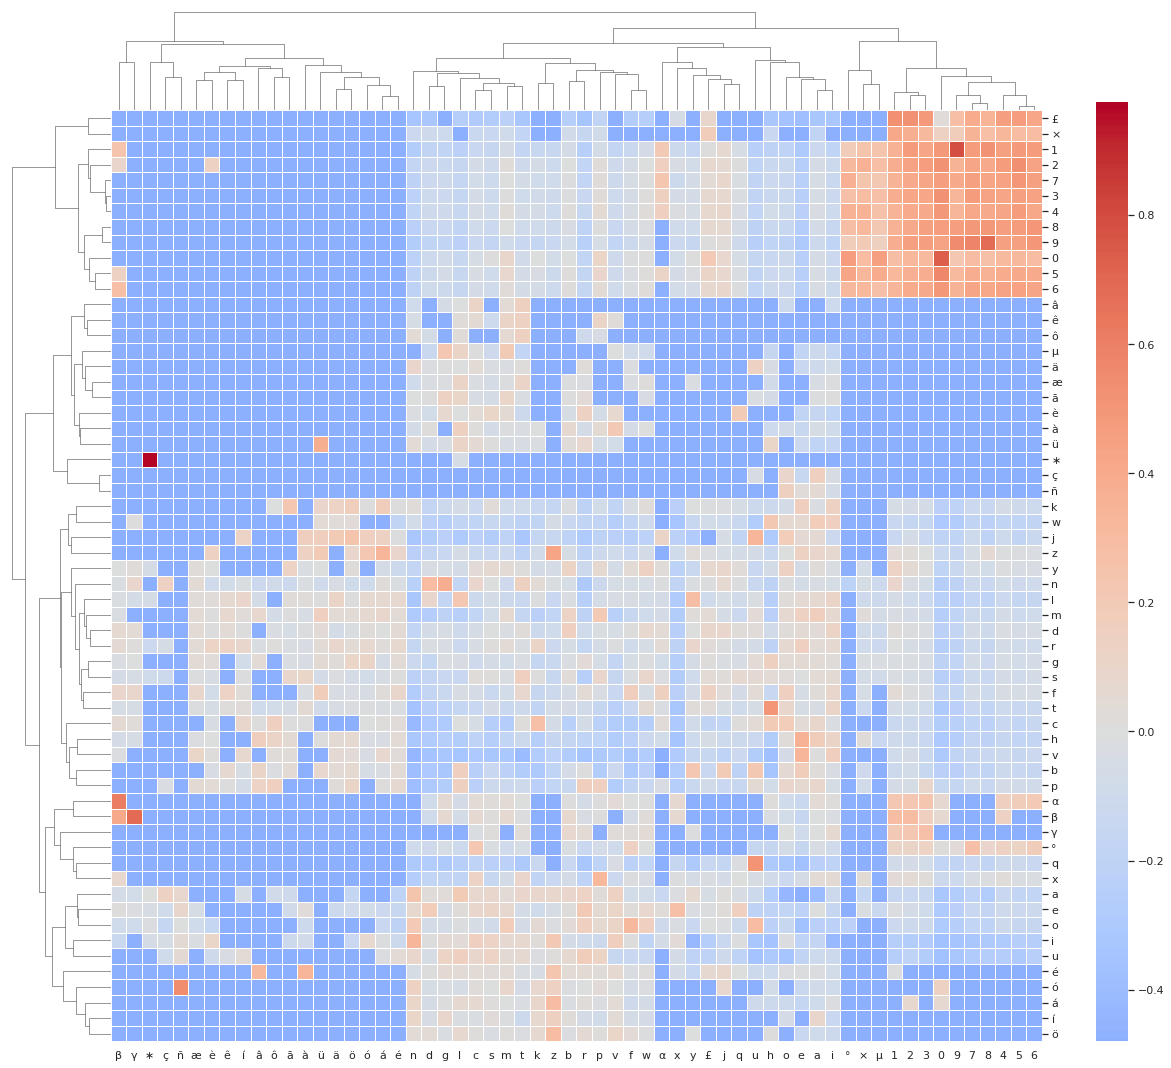

In [27]:
bla = plot_cluster(
    a_M_pmi,
    elements,
    elements,
)

In [37]:
@interact(n=(0,100,1))
def f(n=0):
    matrix = a_M_pmi.copy()
    for l,r in list(ng2.keys())[:n]:
        matrix[elements_dict[l],elements_dict[r]] = 0
    bla = plot_cluster(
        matrix,
        # a_M_pmi.clip(None,.0),
        elements,
        elements,
    )
    return bla

interactive(children=(IntSlider(value=0, description='n'), Output()), _dom_classes=('widget-interact',))

In [43]:
bla.savefig("hcluster_normPMI.pdf")

In [54]:
methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]

findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.


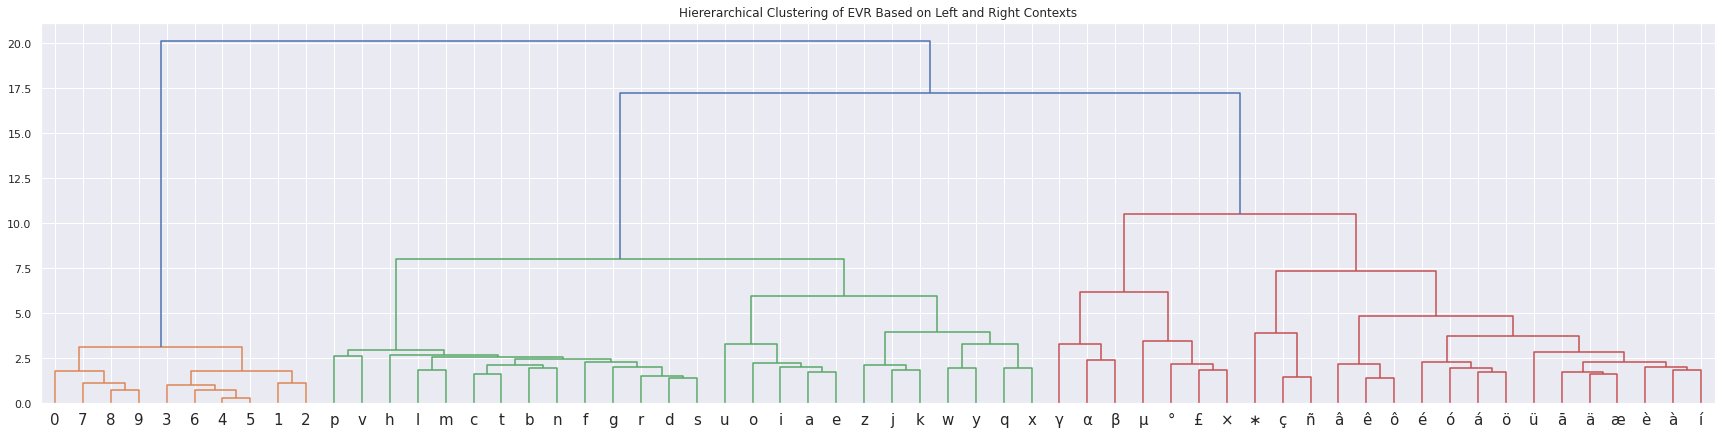

In [28]:
import scipy.cluster.hierarchy as shc

# lr_contexts = np.concatenate((a_M_pmi,a_M_pmi.T), axis=1)
lr_contexts = a_M_pmi + a_M_pmi.T

plt.figure(figsize=(30, 7))  
plt.title("Hiererarchical Clustering of EVR Based on Left and Right Contexts")  
dend = shc.dendrogram(shc.linkage(lr_contexts, method='ward'),
labels=elements,
leaf_rotation=0.,
leaf_font_size=15,
)
# plt.axhline(y=2, color='r', linestyle='--')
# plt.savefig("dendrogram.pdf", bbox_inches='tight')#, format='png')

In [29]:
import plotly.figure_factory as ff

X = np.concatenate((a_M_pmi,a_M_pmi.T), axis=1)
fig = ff.create_dendrogram(X, labels=elements)
fig.update_layout(width=1400, height=500)
fig.show()

In [30]:
import plotly.graph_objects as go
import plotly.figure_factory as ff

import numpy as np

data_array = a_M_pmi
data_array_sym = np.concatenate((a_M_pmi,a_M_pmi.T), axis=1)

labels = elements

# Initialize figure by creating upper dendrogram
fig = ff.create_dendrogram(
    data_array_sym,
    orientation='bottom',
    labels=labels)

for i in range(len(fig['data'])):
    fig['data'][i]['yaxis'] = 'y2'


In [31]:
fig.show()

In [166]:

# Create Side Dendrogram
dendro_side = ff.create_dendrogram(
    data_array_sym,
    orientation='right',
    labels=labels
    )

dendro_side.update_yaxes(side="right")

for i in range(len(dendro_side['data'])):
    dendro_side['data'][i]['xaxis'] = 'x2'

# Add Side Dendrogram Data to Figure
for data in dendro_side['data']:
    fig.add_trace(data)

In [167]:
dendro_side

In [168]:

# Create Heatmap
dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
# dendro_leaves = list(map(int, dendro_leaves))
dendro_leaves = [elements_dict[i] for i in dendro_leaves]

# data_dist = pdist(data_array)
# heat_data = squareform(data_dist)

heat_data = data_array
heat_data = heat_data[dendro_leaves,:]
heat_data = heat_data[:,dendro_leaves]

heatmap = [
    go.Heatmap(
        x = dendro_leaves,
        y = dendro_leaves,
        z = heat_data,
        colorscale = 'Oranges',
        
    )
]

heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']


# Add Heatmap Data to Figure
for data in heatmap:
    fig.add_trace(data)


In [169]:
fig.show()

In [170]:

# Edit Layout
fig.update_layout({'width':1200, 'height':1200,
                         'showlegend':False, 'hovermode': 'closest',
                         })


In [171]:
# Edit xaxis
fig.update_layout(xaxis={'domain': [.15, 1],
                                  'mirror': False,
                                  'showgrid': False,
                                  'showline': False,
                                  'zeroline': False,
                                  'showticklabels': True,
                                  'ticks':""})


In [172]:
# Edit xaxis2
fig.update_layout(xaxis2={'domain': [0, .15],
                                   'mirror': False,
                                   'showgrid': False,
                                   'showline': False,
                                   'zeroline': False,
                                   'showticklabels': True,
                                   'ticks':""})


In [173]:

# Edit yaxis
fig.update_layout(yaxis={'domain': [0, .85],
                                  'mirror': False,
                                  'showgrid': False,
                                  'showline': False,
                                  'zeroline': False,
                                  'showticklabels': True,
                                  'ticks': ""
                        })
# Edit yaxis2
fig.update_layout(yaxis2={'domain':[.825, .975],
                                   'mirror': False,
                                   'showgrid': False,
                                   'showline': False,
                                   'zeroline': False,
                                   'showticklabels': False,
                                   'ticks':""})

# Plot!
fig.show()

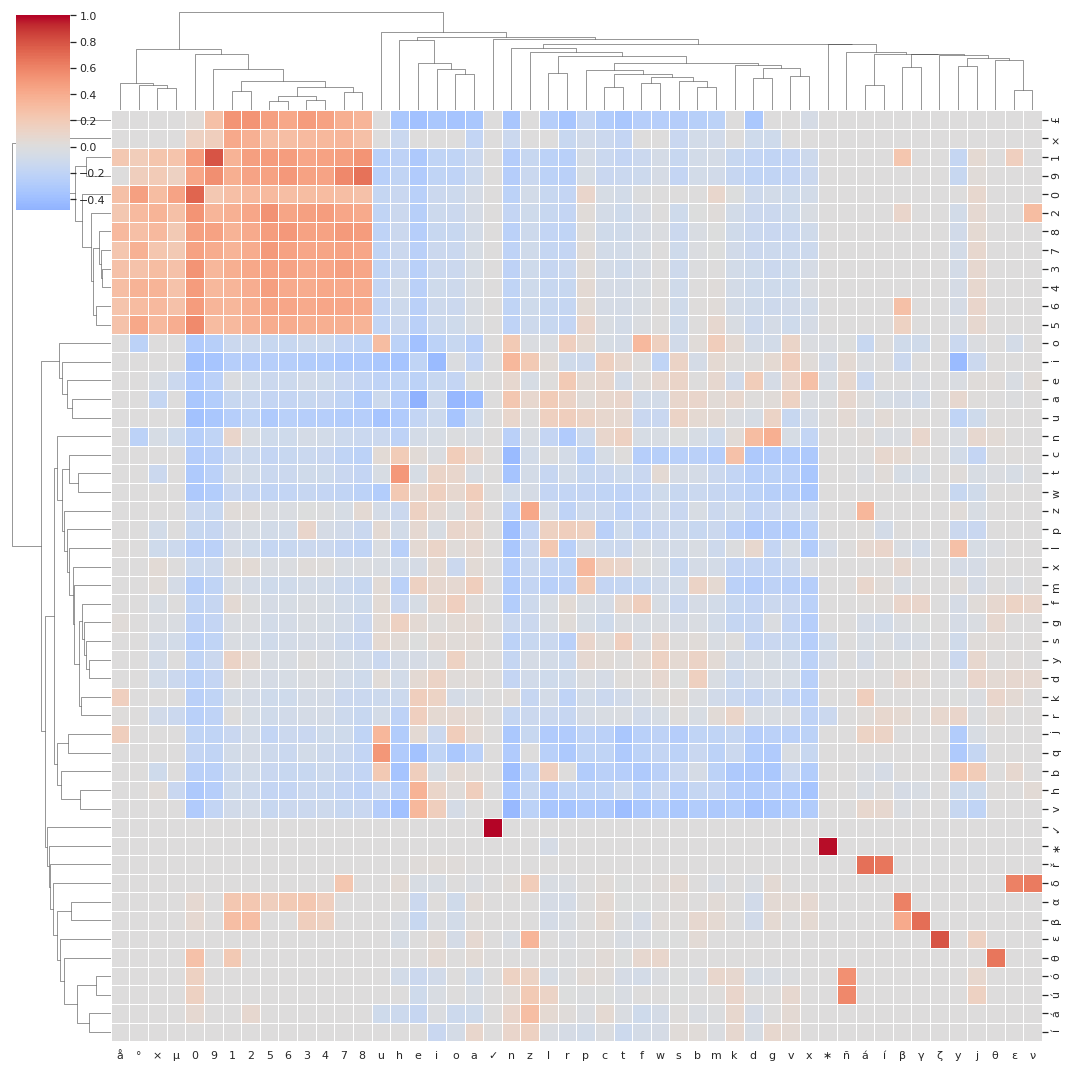

In [265]:
row_index = bla.dendrogram_row.reordered_ind
col_index = bla.dendrogram_col.reordered_ind

b = None
n = 50

bla_trim = plot_cluster(
    a_M_pmi[row_index[b:n]][:,col_index[b:n]],
    [elements[i] for i in col_index[b:n]],
    [elements[i] for i in row_index[b:n]],
)

In [254]:
bla_trim.savefig("hcluster_normPMI_trim.pdf")

In [189]:
bla.savefig("heatmap.pdf")

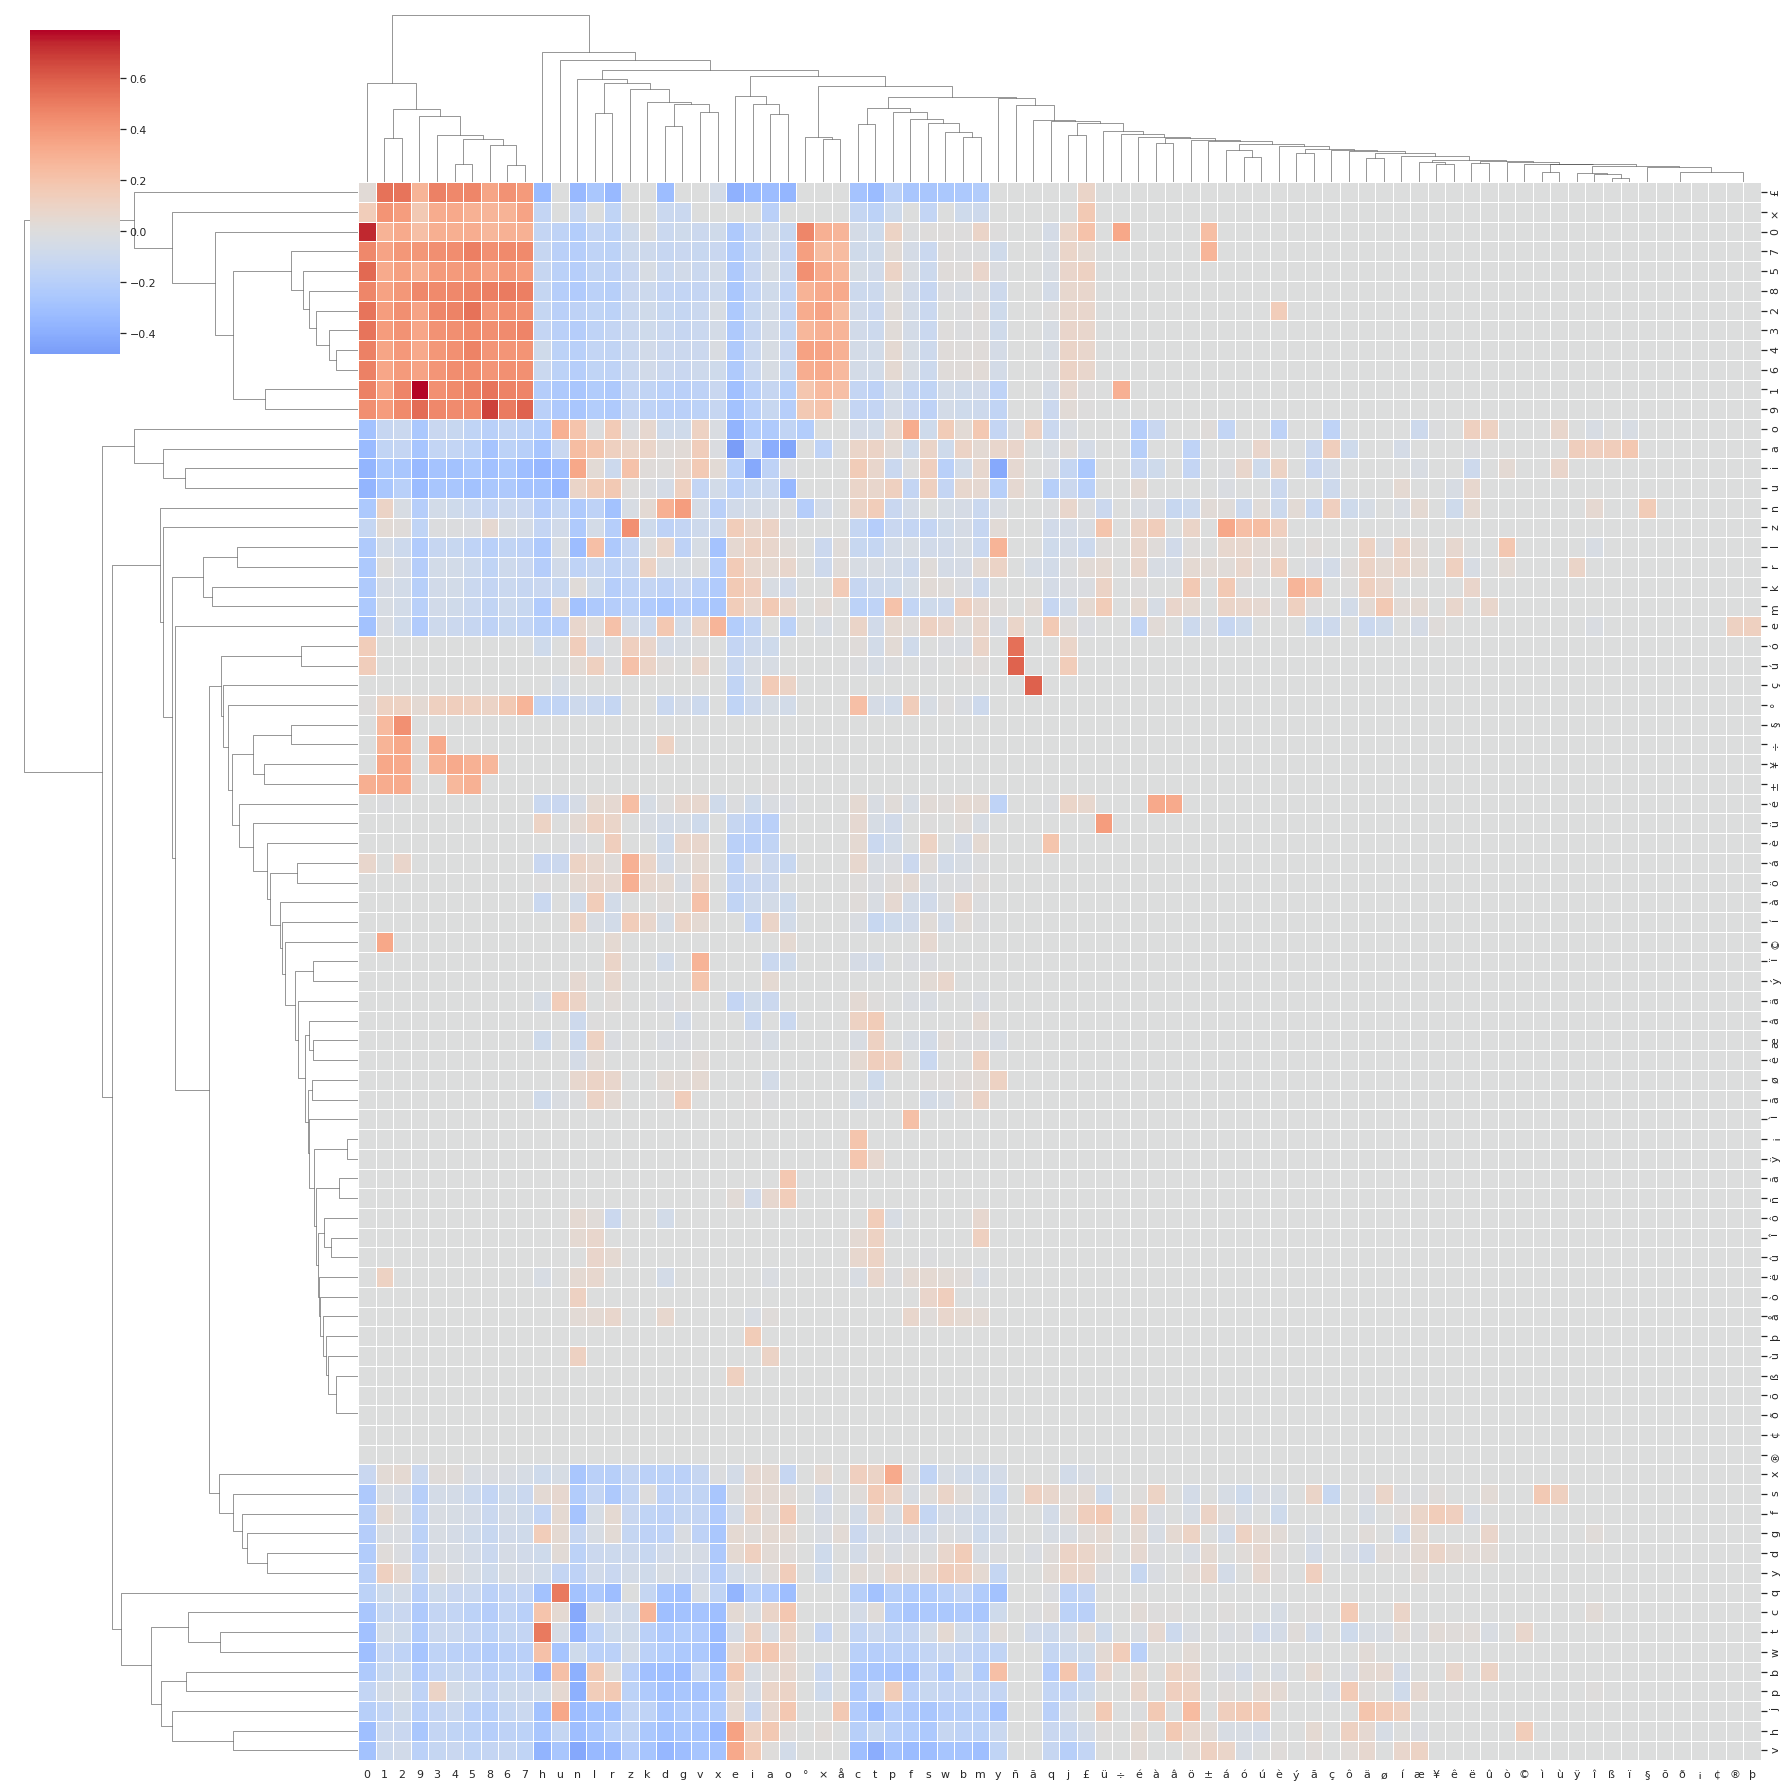

In [ ]:
bla = plot_cluster(
    a_M_pmi,
    elements,
    elements,
)

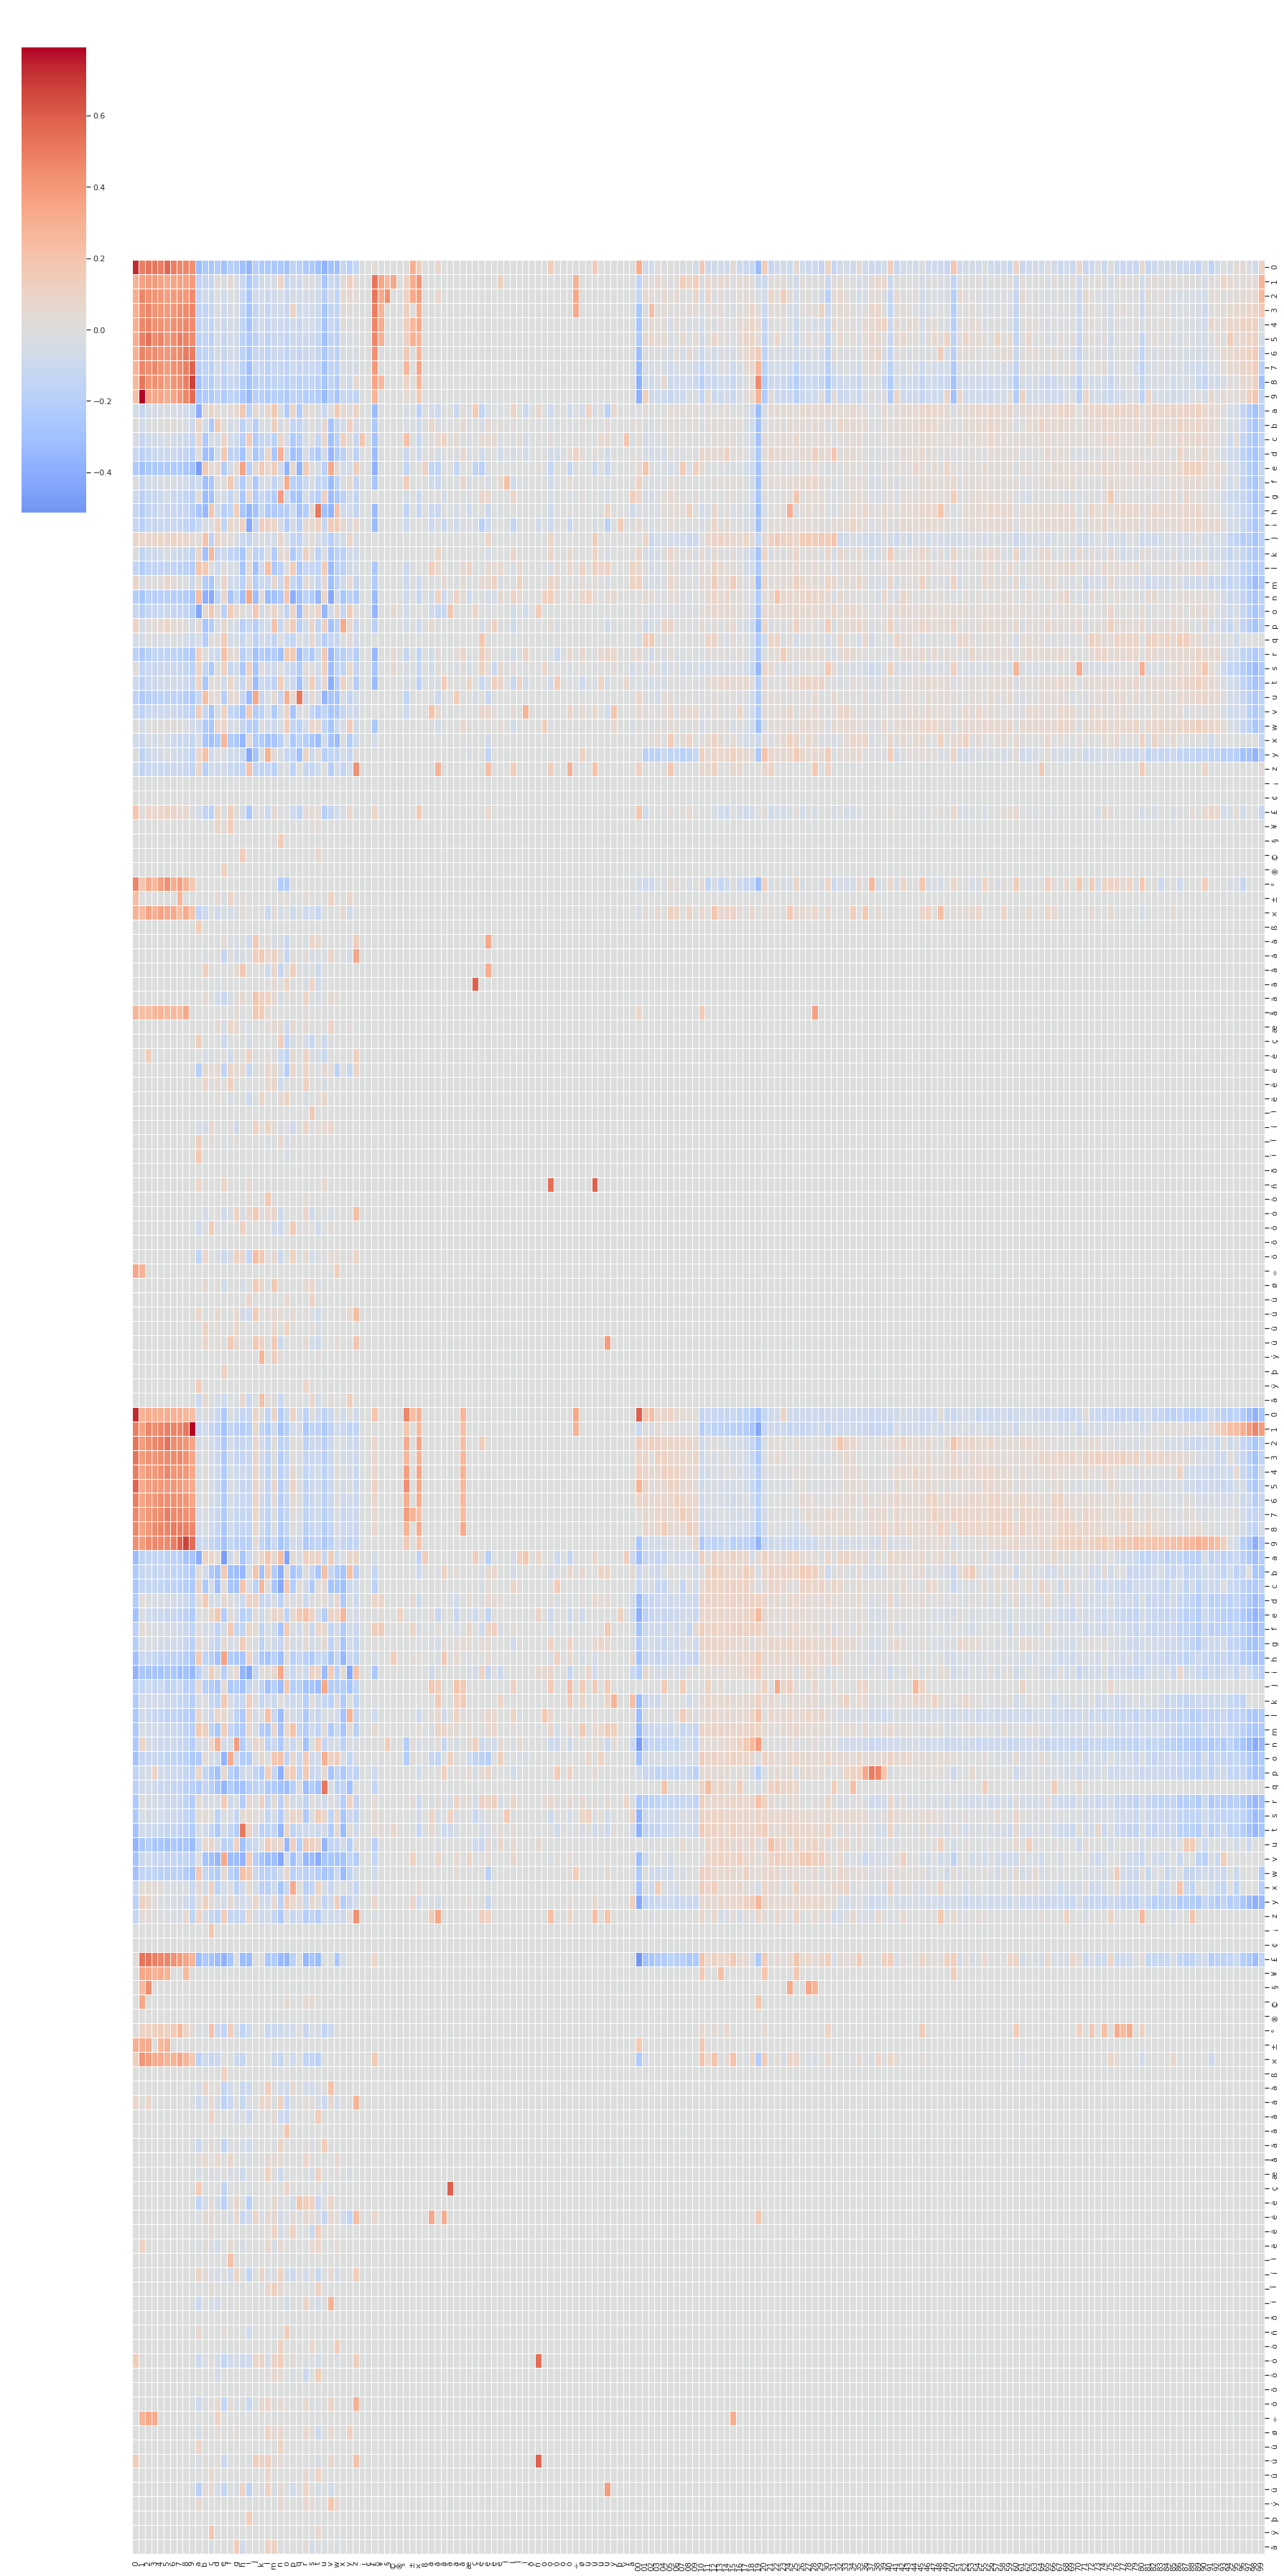

In [ ]:
plot_cluster(np.concatenate(
    (
    np.concatenate((a_M_pmi.T, a_M_pmi), axis=0),
    np.concatenate((a_M_21_pmi.T, a_M_12_pmi), axis=0)),
    axis=1),
    elements+elements_2,
    elements*2
    )

# Work so far

In [5]:
cp_r = {n:sorted([(k[-1],v) for k,v in ng2_bpe.items() if k[:1]==str(n)],reverse=True, key=lambda x:x[-1]) for n in range(10)}

In [8]:
pmi_r = {n: sorted([(k,v) for k,v in zip(elements,a_M_pmi[elements_dict[str(n)]].tolist())],reverse=True,key=lambda x: x[-1])

    
    # [(k[-1],v) for k,v in ng2.items() if k[:2]==str(n)],reverse=True, key=lambda x:x[-1])
    
     for n in range(0,10)}

In [11]:
[[i for i in pmi_r[n][:11]] for n in range(10)]

[[('0', 3.239390785133873),
  ('1', 2.7853212785340804),
  ('7', 2.3761211636192323),
  ('2', 2.206654510477851),
  ('5', 2.1942235388357925),
  ('9', 2.189282645878351),
  ('3', 2.0600164731816135),
  ('8', 2.0468967618604204),
  ('4', 1.993404894799551),
  ('6', 1.7481263107702654),
  ('e', 0.0)],
 [('8', 2.8168407164261633),
  ('6', 2.7506331966203685),
  ('2', 2.7360211187420487),
  ('7', 2.7190738245844392),
  ('4', 2.604819669354788),
  ('3', 2.5717021086575493),
  ('1', 2.490555092386809),
  ('5', 2.357843428947975),
  ('9', 2.2751248422567323),
  ('0', 2.065975719022839),
  ('e', 0.0)],
 [('3', 2.742892970122236),
  ('4', 2.6843007807656187),
  ('2', 2.59036550099006),
  ('5', 2.5772353595377266),
  ('9', 2.5603868133221748),
  ('1', 2.5148790152858207),
  ('6', 2.470246780788278),
  ('7', 2.3895376869771376),
  ('0', 2.3762020490889784),
  ('8', 2.371919427349212),
  ('e', 0.0)],
 [('0', 2.6764861825005055),
  ('1', 2.669101310195923),
  ('7', 2.565524157410244),
  ('6', 2.558

In [10]:
pmi_r

{0: [('0', 3.239390785133873),
  ('1', 2.7853212785340804),
  ('7', 2.3761211636192323),
  ('2', 2.206654510477851),
  ('5', 2.1942235388357925),
  ('9', 2.189282645878351),
  ('3', 2.0600164731816135),
  ('8', 2.0468967618604204),
  ('4', 1.993404894799551),
  ('6', 1.7481263107702654),
  ('e', 0.0),
  ('t', 0.0),
  ('a', 0.0),
  ('o', 0.0),
  ('i', 0.0),
  ('n', 0.0),
  ('s', 0.0),
  ('r', 0.0),
  ('h', 0.0),
  ('l', 0.0),
  ('d', 0.0),
  ('c', 0.0),
  ('u', 0.0),
  ('m', 0.0),
  ('f', 0.0),
  ('p', 0.0),
  ('g', 0.0),
  ('w', 0.0),
  ('y', 0.0),
  ('b', 0.0),
  ('v', 0.0),
  ('k', 0.0),
  ('x', 0.0),
  ('j', 0.0),
  ('q', 0.0),
  ('z', 0.0),
  ('£', 0.0),
  ('é', 0.0),
  ('°', 0.0),
  ('è', 0.0),
  ('×', 0.0),
  ('ü', 0.0),
  ('á', 0.0),
  ('μ', 0.0),
  ('ö', 0.0),
  ('ç', 0.0),
  ('ó', 0.0),
  ('β', 0.0),
  ('í', 0.0),
  ('α', 0.0),
  ('ä', 0.0),
  ('∗', 0.0)],
 1: [('8', 2.8168407164261633),
  ('6', 2.7506331966203685),
  ('2', 2.7360211187420487),
  ('7', 2.7190738245844392),
  (

In [152]:
elements_2 = [i+j for i in elements for j in elements]
elements_2_dict = {k:i for i,k in enumerate(elements_2)}

a_M_3 = slg.util.build_term_context_matrix(elements_2, elements, ng3_bpe)
a_M_3 = a_M_3.toarray()
a_M_3_pmi = slg.util.build_pmi_matrix(a_M_3)
a_M_3_pmi = a_M_3_pmi.toarray()

Building oR Matrix...
Term-Context Matrix built in 2.21 secs.

Computing PMI Matrix...
Type: pmi
Done
PMI Matrix built in 0.03 secs.
Done



In [155]:
pmi_3_r = {n: sorted([(k,v) for k,v in zip(elements,a_M_3_pmi[elements_2_dict[str(n)]].tolist())],reverse=True,key=lambda x: x[-1])


    
    
    # [(k[-1],v) for k,v in ng2.items() if k[:2]==str(n)],reverse=True, key=lambda x:x[-1])
    
     for n in range(10,100)}

In [157]:
[[i[0] for i in pmi_3_r[n][:10]] for n in range(10,100)]

[['1', '3', '4', '0', '6', '8', '9', '7', '2', '5'],
 ['1', '2', '4', '3', '8', '6', '7', '5', '9', '0'],
 ['1', '3', '8', '4', '5', '7', '6', '9', '2', '0'],
 ['4', '3', '8', '7', '2', '5', '0', 'e', 't', 'a'],
 ['4', '5', '0', 'e', 't', 'a', 'o', 'i', 'n', 's'],
 ['4', '2', '0', '5', 'e', 't', 'a', 'o', 'i', 'n'],
 ['5', '0', 'e', 't', 'a', 'o', 'i', 'n', 's', 'r'],
 ['5', '0', 'e', 't', 'a', 'o', 'i', 'n', 's', 'r'],
 ['9', '0', '5', 'e', 't', 'a', 'o', 'i', 'n', 's'],
 ['9', '8', '7', '6', '5', '2', '0', 'e', 't', 'a'],
 ['0', 'e', 't', 'a', 'o', 'i', 'n', 's', 'r', 'h'],
 ['2', '0', 'e', 't', 'a', 'o', 'i', 'n', 's', 'r'],
 ['3', '5', '0', 'e', 't', 'a', 'o', 'i', 'n', 's'],
 ['0', 'e', 't', 'a', 'o', 'i', 'n', 's', 'r', 'h'],
 ['0', 'e', 't', 'a', 'o', 'i', 'n', 's', 'r', 'h'],
 ['0', 'e', 't', 'a', 'o', 'i', 'n', 's', 'r', 'h'],
 ['e', 't', 'a', 'o', 'i', 'n', 's', 'r', 'h', 'l'],
 ['0', 'e', 't', 'a', 'o', 'i', 'n', 's', 'r', 'h'],
 ['0', 'e', 't', 'a', 'o', 'i', 'n', 's', 'r',

In [15]:
import string
from collections import Counter,defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np

from itertools import compress
from scipy import sparse

In [135]:
elements[51]

'∗'

In [109]:
level = "nums"

if level == "tags":
    ng1 = slg.util.load_file("wip/res_bnc/ng_t_1.json")
    ng2 = slg.util.load_file("wip/res_bnc/ng_t_2.json")
    ng3 = slg.util.load_file("wip/res_bnc/ng_t_3.json")
    ng4 = slg.util.load_file("wip/res_bnc/ng_t_4.json")

elif level in {"words", "nums"}:
    ng1 = slg.util.load_file("wip/res_bnc/ng_w_1.json")
    ng2 = slg.util.load_file("wip/res_bnc/ng_w_2.json")
    ng3 = slg.util.load_file("wip/res_bnc/ng_w_3_5.json")
    ng4 = slg.util.load_file("wip/res_bnc/ng_w_4_5.json")

elif level == "chars":
    ng1 = slg.util.load_file("models/en_bnc/vocabulary/alpha.json")
    ng2 = slg.util.load_file("models/en_bnc/vocabulary/ngrams_rem/big_ng/2.json")
    ng3 = slg.util.load_file("models/en_bnc/vocabulary/ngrams_rem/big_ng/3.json")
    ng4 = slg.util.load_file("models/en_bnc/vocabulary/ngrams_rem/big_ng/4.json")

In [110]:
thres = 100

if level == "chars":

    ng1 = {k:v for k,v in ng1.items() if v>=thres}
    ng2 = {tuple(list(k)):v for k,v in ng2.items() if v>=thres}
    ng3 = {tuple(list(k)):v for k,v in ng3.items() if v>=thres}
    ng4 = {tuple(list(k)):v for k,v in ng4.items() if v>=thres}
    
elif level == "words":
    ng2 = {tuple(k.split()):v for k,v in ng2.items() if v>=thres}
    ng3 = {tuple(k.split()):v for k,v in ng3.items() if v>=thres}
    ng4 = {tuple(k.split()):v for k,v in ng4.items() if v>=thres}

    ng2 = {k:v for k,v in ng2.items() if len(k)>1 and all([kn not in ",.'‘’?!"+string.punctuation for kn in k])}
    ng3 = {k:v for k,v in ng3.items() if len(k)>2 and all([kn not in ",.'‘’?!"+string.punctuation for kn in k])}
    ng4 = {k:v for k,v in ng4.items() if len(k)>3 and all([kn not in ",.'‘’?!"+string.punctuation for kn in k])}

elif level == "nums":

    ng1 = {k:v for k,v in ng1.items() if len(k)>0 and set(k).issubset(set(string.digits))}

else:    
    ng2 = {tuple(k.split()):v for k,v in ng2.items() if v>=thres}
    ng3 = {tuple(k.split()):v for k,v in ng3.items() if v>=thres}
    ng4 = {tuple(k.split()):v for k,v in ng4.items() if v>=thres}

In [14]:
if level == "chars":
    elements = string.digits[1:]
    
else:
    elements = ng1.keys()

if level == "words":
    elements = [e for e in elements if e not in ",.'‘’?!"+string.punctuation]#[:100000]

elements = list(elements)
elements_dict = {k:i for i,k in enumerate(elements)}
elements_len = len(elements)

In [26]:
a_M = slg.util.build_term_context_matrix(elements, elements, ng2)
a_M = a_M.toarray()

Building oR Matrix...
Term-Context Matrix built in 0.0 secs.



<AxesSubplot:>

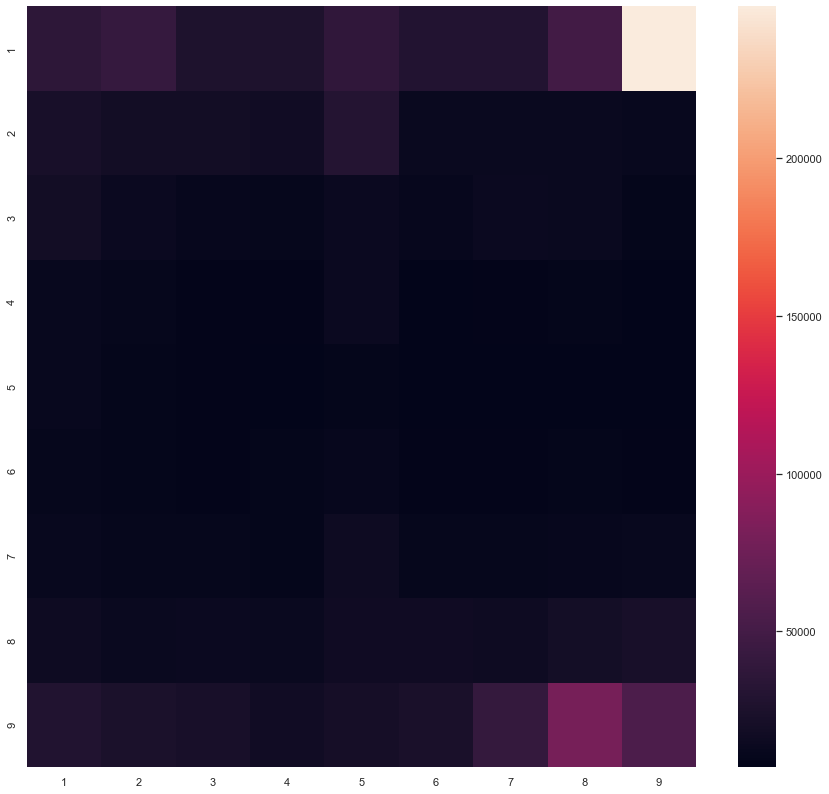

In [24]:
plot(a_M.todense())

In [28]:
a_M_l = normalize(a_M, "l1", axis=1)

In [33]:
a_M_l[0]

array([0.06787285, 0.07910735, 0.0506717 , 0.05085118, 0.07157313,
       0.05618776, 0.0562985 , 0.09343114, 0.47400638])

In [34]:
a_M_l[1]

array([0.13983641, 0.11903185, 0.11948591, 0.11036696, 0.18743024,
       0.08231644, 0.08107409, 0.08413897, 0.07631913])

In [38]:
normalize([[ng1[i] for i in elements]],"l1")

array([[0.25789372, 0.11806138, 0.08899872, 0.07180581, 0.08772454,
        0.06635135, 0.06924778, 0.09034696, 0.14956974]])

In [124]:
ben_2d = defaultdict(int)
for i in range(1,10):
    ben_2d[i] = sum([v for k,v in ng1.items() if
    len(k)>1  and
    k[1] == str(i)
    and k not in [str(n) for n in range(1700,2000)]
    and k not in [str(n)+"5" for n in range(1,10)]
    ])

In [125]:
bla = normalize([list(ben_2d.values())],"l1")

In [126]:
from math import log10
bla2 = [log10(1+1/n) for n in range(1,10)]

<AxesSubplot:title={'center':'Title'}, xlabel='x', ylabel='f(x)'>

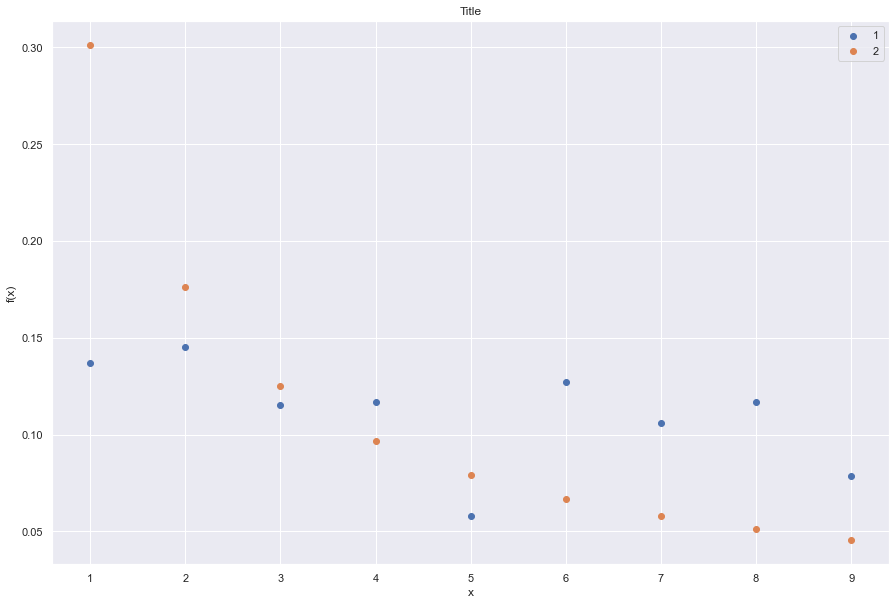

In [127]:
slg.util.scatter_plot([bla[0],bla2],list(range(1,10)))